# Smart Time Slot Recommendation for Job Scheduling in Shared GPU Environments.

In [ ]:
!pip install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


## Load and Preprocess Data (Turnaround Time)

### Subtask:
Load the data and perform necessary preprocessing, including handling missing values and creating relevant features, ensuring `total_around_time` is the target variable for prediction.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xg
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# Load the data from the specified URLs
df = pd.DataFrame()
l = ["05","10","20","25","33"]
for num in l:
  df1 = pd.read_csv("https://raw.githubusercontent.com/alibaba/clusterdata/refs/heads/master/cluster-trace-gpu-v2023/csv/openb_pod_list_gpuspec"+num+".csv")
  df = pd.concat([df,df1])

l = ["0","037","050","072","100","200","235","250","300"]
for num in l:
  df1 = pd.read_csv("https://raw.githubusercontent.com/alibaba/clusterdata/refs/heads/master/cluster-trace-gpu-v2023/csv/openb_pod_list_cpu"+num+".csv")
  df = pd.concat([df,df1])

df1 = pd.read_csv("https://raw.githubusercontent.com/alibaba/clusterdata/refs/heads/master/cluster-trace-gpu-v2023/csv/openb_pod_list_default.csv")
df = pd.concat([df,df1])

l = ["100","40","20","60","80"]
for num in l:
  df1 = pd.read_csv("https://raw.githubusercontent.com/alibaba/clusterdata/refs/heads/master/cluster-trace-gpu-v2023/csv/openb_pod_list_gpushare"+num+".csv")
  df = pd.concat([df,df1])


# Drop columns with more than 90% missing values
df.drop(df.loc[:,(df.isna().sum()/df.shape[0])*100>90].columns,axis=1,inplace=True)

# Convert integer timestamps to datetime, coercing errors
df['creation_time'] = pd.to_datetime(df['creation_time'], unit='s', errors='coerce')
df['deletion_time'] = pd.to_datetime(df['deletion_time'], unit='s', errors='coerce')
df['scheduled_time'] = pd.to_datetime(df['scheduled_time'], unit='s', errors='coerce')


# Calculate turnaround time (in minutes) - handle potential NaT
df['total_around_time'] = (df['deletion_time'] - df['creation_time']).dt.total_seconds() / 60

# Drop rows where total_around_time is NaN (due to NaT in creation_time or deletion_time)
df.dropna(subset=['total_around_time'], inplace=True)


# Feature Engineering
df['wait_time'] = (df['scheduled_time'] - df['creation_time']).dt.total_seconds()
df['execution_time'] = (df['deletion_time'] - df['scheduled_time']).dt.total_seconds()
df['job_hour'] = df['creation_time'].dt.hour
df['job_dayofweek'] = df['creation_time'].dt.dayofweek
df['is_peak_hour'] = df['job_hour'].apply(lambda x: 1 if 10 <= x <= 18 else 0)
df['gpu_demand_ratio'] = (df['gpu_milli'] / 1000) * df['num_gpu']


# QoS Level Encoding
qos_map = {'BE': 3, 'Burstable': 2, 'Guaranteed': 1,'LS':0}
df['qos_level'] = df['qos'].map(qos_map)

# Drop original time columns and 'name', 'qos'
df.drop(['creation_time', 'deletion_time', 'scheduled_time', 'name', 'qos'], axis=1, inplace=True)

# One Hot encoding for pod_phase column
df = pd.get_dummies(df, columns=['pod_phase'])

# Ensure consistent column types after one-hot encoding
for col in ['pod_phase_Failed', 'pod_phase_Running', 'pod_phase_Succeeded']:
    if col not in df.columns:
        df[col] = 0 # Add missing pod_phase columns with default 0
    df[col] = df[col].astype(int) # Ensure integer type

display(df.head())
display(df.info())
display(df.isna().sum())

,cpu_milli,memory_mib,num_gpu,gpu_milli,total_around_time,wait_time,execution_time,job_hour,job_dayofweek,is_peak_hour,gpu_demand_ratio,qos_level,pod_phase_Failed,pod_phase_Pending,pod_phase_Running,pod_phase_Succeeded
0,12000,16384,1,1000,208958.266667,0.0,12537496.0,0,3,0,1.00,0,0,False,1,0
1,6000,12288,1,460,207931.650000,0.0,12475899.0,22,0,0,0.46,0,0,False,1,0
2,12000,24576,1,1000,189076.316667,0.0,11344579.0,0,0,0,1.00,0,0,False,1,0
3,6000,12288,1,460,170215.266667,0.0,10212916.0,3,6,0,0.46,0,0,False,1,0
4,12000,16384,1,1000,169081.266667,0.0,10144876.0,22,6,0,1.00,0,0,False,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 164558 entries, 0 to 8151
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   cpu_milli            164558 non-null  int64  
 1   memory_mib           164558 non-null  int64  
 2   num_gpu              164558 non-null  int64  
 3   gpu_milli            164558 non-null  int64  
 4   total_around_time    164558 non-null  float64
 5   wait_time            145825 non-null  float64
 6   execution_time       145825 non-null  float64
 7   job_hour             164558 non-null  int32  
 8   job_dayofweek        164558 non-null  int32  
 9   is_peak_hour         164558 non-null  int64  
 10  gpu_demand_ratio     164558 non-null  float64
 11  qos_level            164558 non-null  int64  
 12  pod_phase_Failed     164558 non-null  int64  
 13  pod_phase_Pending    164558 non-null  bool   
 14  pod_phase_Running    164558 non-null  int64  
 15  pod_phase_Succeeded  164

None

,0
cpu_milli,0
memory_mib,0
num_gpu,0
gpu_milli,0
total_around_time,0
wait_time,18733
execution_time,18733
job_hour,0
job_dayofweek,0
is_peak_hour,0


## Analyze Turnaround Time

### Subtask:
Explore the distribution and characteristics of `total_around_time` and identify potential factors influencing it.

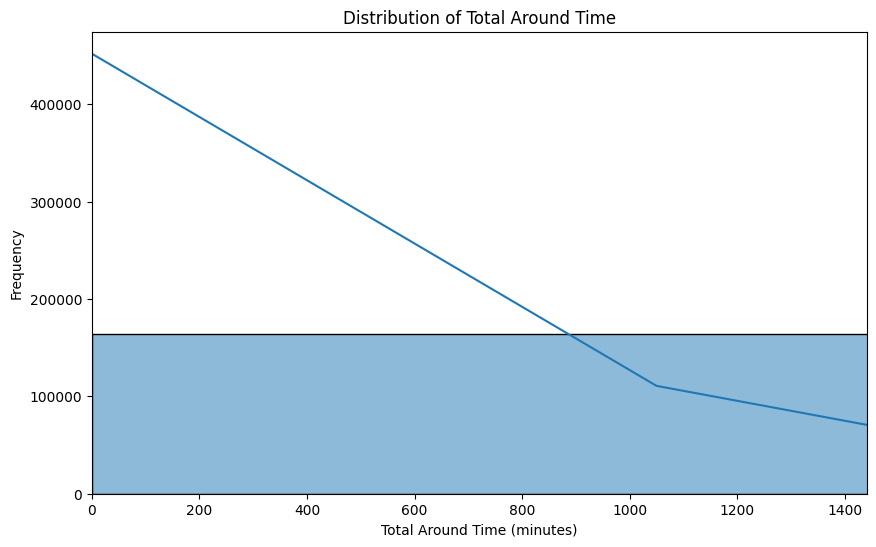


Descriptive Statistics for Total Around Time:
count    164558.000000
mean        410.872961
std        6527.419079
min           0.000000
25%           2.700000
50%           8.900000
75%          32.183333
max      208958.266667
Name: total_around_time, dtype: float64


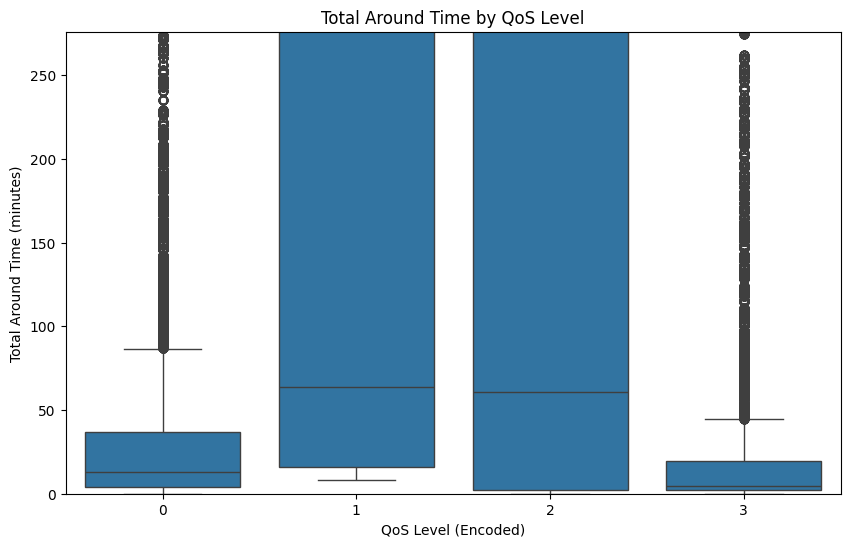

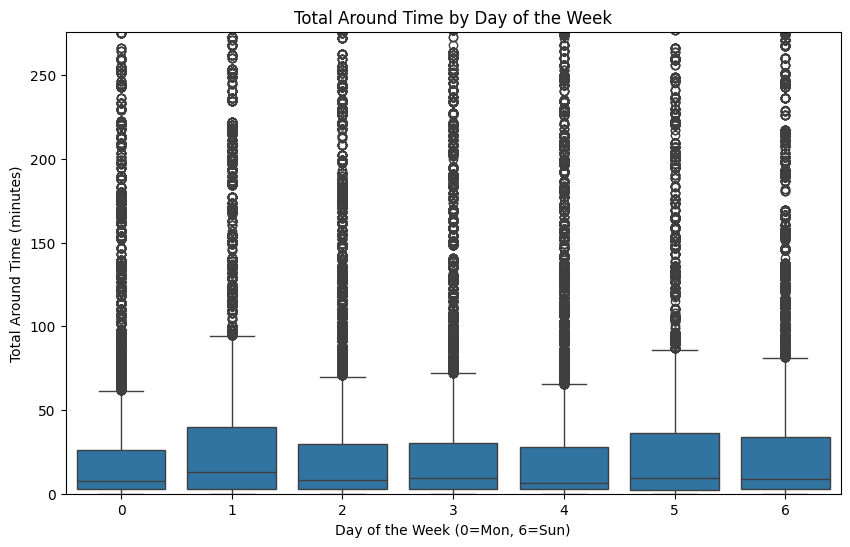

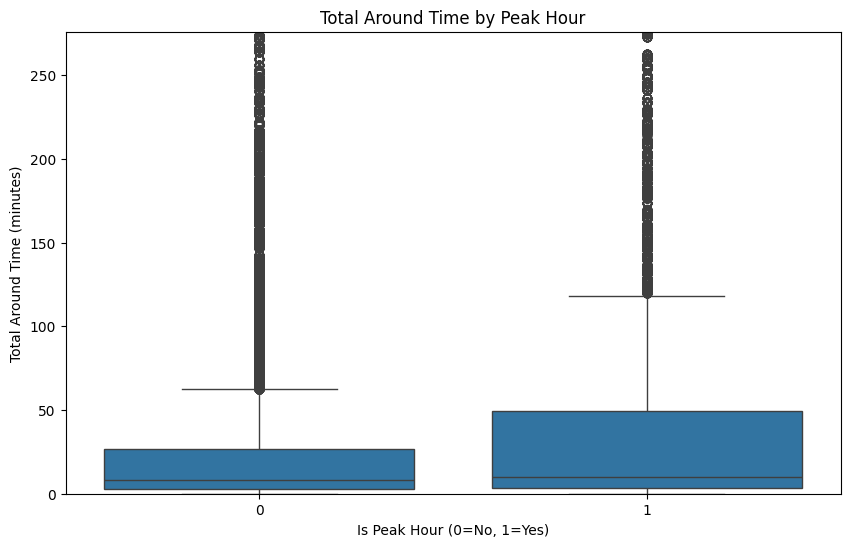

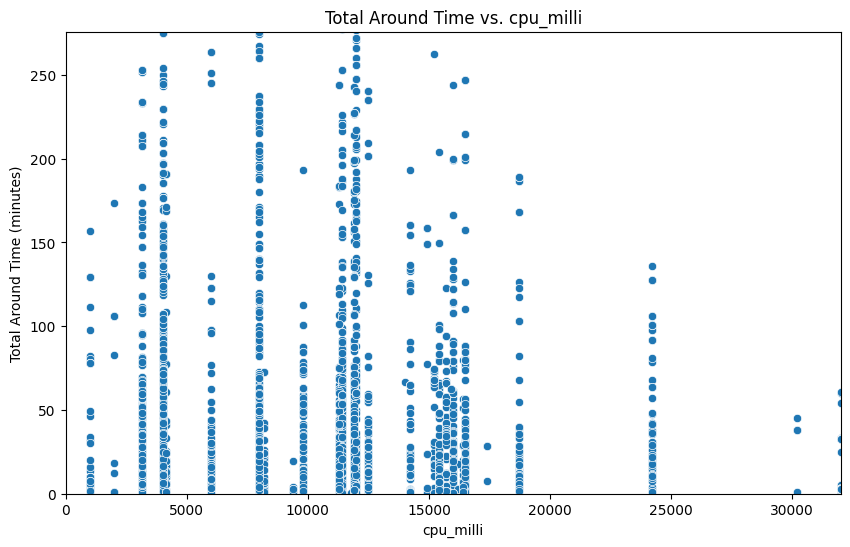

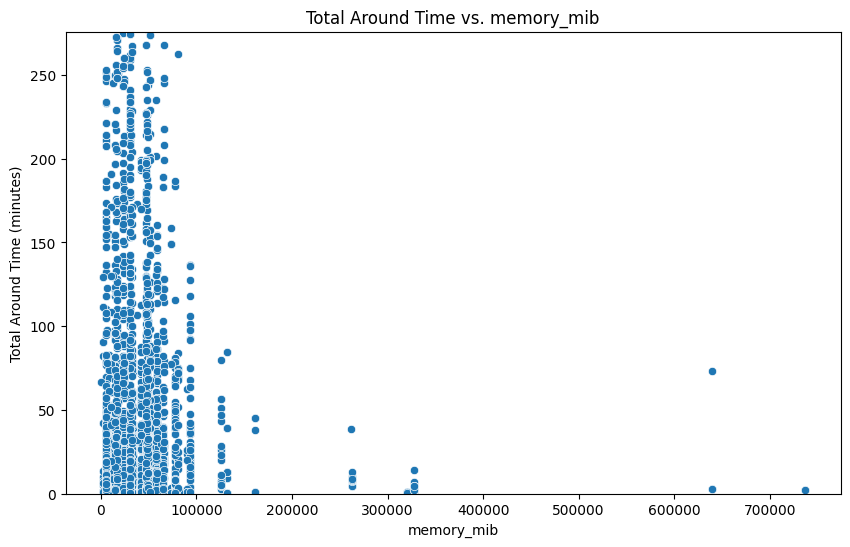

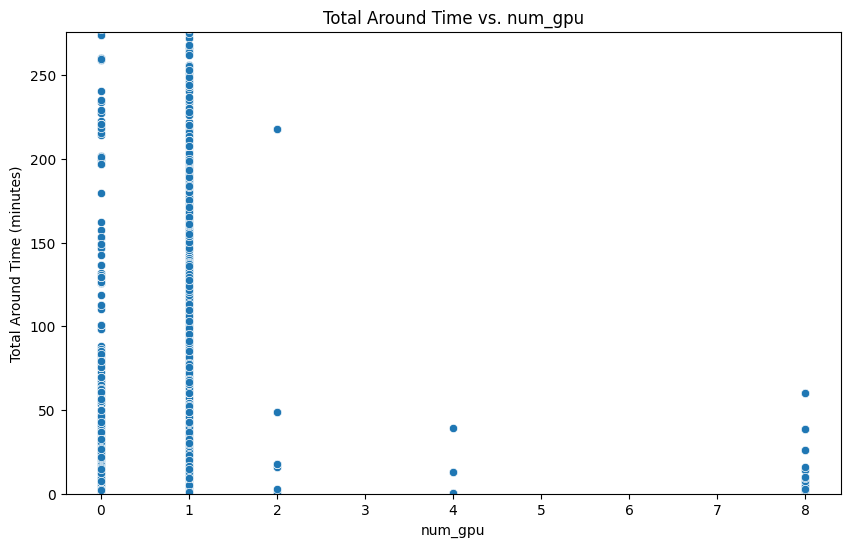

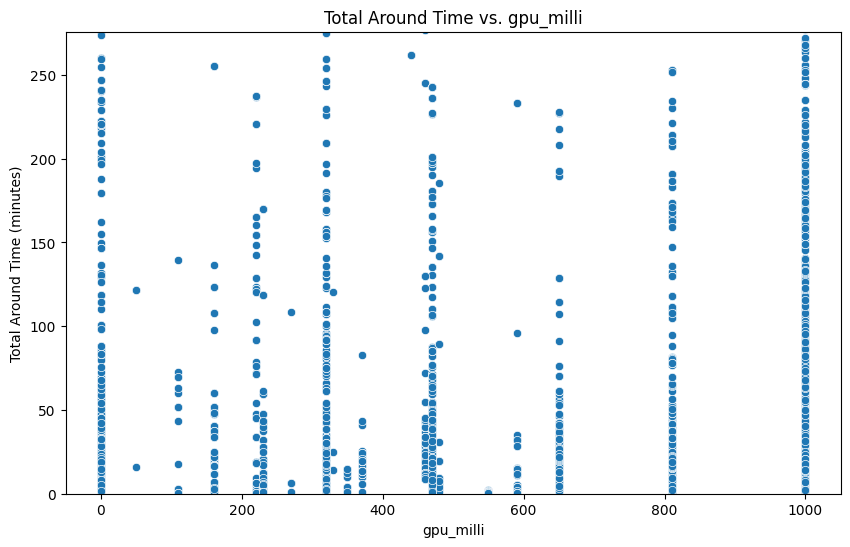

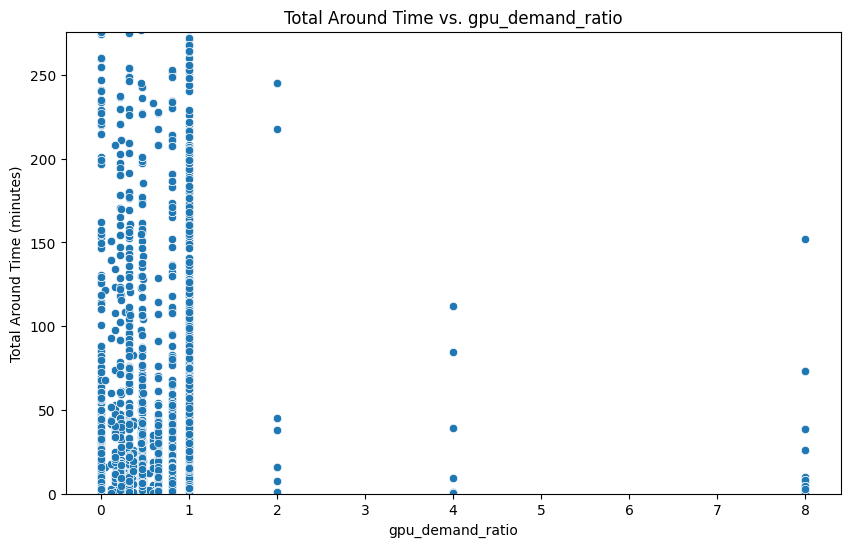


Correlation with Total Around Time:
total_around_time    1.000000
gpu_demand_ratio     0.011998
gpu_milli            0.011175
cpu_milli            0.010514
num_gpu              0.010351
memory_mib          -0.012402
Name: total_around_time, dtype: float64


In [ ]:
# 1. Visualize the distribution of total_around_time
plt.figure(figsize=(10, 6))
sns.histplot(df['total_around_time'], bins=50, kde=True)
plt.title('Distribution of Total Around Time')
plt.xlabel('Total Around Time (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, df['total_around_time'].quantile(0.99))
plt.show()

# 2. Calculate and print descriptive statistics
print("\nDescriptive Statistics for Total Around Time:")
print(df['total_around_time'].describe())

# 3. Examine the relationship between total_around_time and categorical features

# Box plot for QoS Level vs. Total Around Time
plt.figure(figsize=(10, 6))
sns.boxplot(x='qos_level', y='total_around_time', data=df)
plt.title('Total Around Time by QoS Level')
plt.xlabel('QoS Level (Encoded)')
plt.ylabel('Total Around Time (minutes)')
plt.ylim(0, df['total_around_time'].quantile(0.95)) # Limit y-axis for better visualization
plt.show()

# Box plot for Day of the Week vs. Total Around Time
plt.figure(figsize=(10, 6))
sns.boxplot(x='job_dayofweek', y='total_around_time', data=df)
plt.title('Total Around Time by Day of the Week')
plt.xlabel('Day of the Week (0=Mon, 6=Sun)')
plt.ylabel('Total Around Time (minutes)')
plt.ylim(0, df['total_around_time'].quantile(0.95)) # Limit y-axis for better visualization
plt.show()

# Box plot for Peak Hour vs. Total Around Time
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_peak_hour', y='total_around_time', data=df)
plt.title('Total Around Time by Peak Hour')
plt.xlabel('Is Peak Hour (0=No, 1=Yes)')
plt.ylabel('Total Around Time (minutes)')
plt.ylim(0, df['total_around_time'].quantile(0.95)) # Limit y-axis for better visualization
plt.show()


# 4. Explore the relationship between total_around_time and numerical features
numerical_features = ['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli', 'gpu_demand_ratio']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='total_around_time', data=df.sample(10000)) # Sample for performance
    plt.title(f'Total Around Time vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Total Around Time (minutes)')
    plt.ylim(0, df['total_around_time'].quantile(0.95)) # Limit y-axis for better visualization
    # Optional: Limit x-axis for features with extreme outliers
    if df[feature].quantile(0.99) > df[feature].quantile(0.75) * 2: # Heuristic to check for potential outliers
         plt.xlim(0, df[feature].quantile(0.99))
    plt.show()

# Correlation analysis with numerical features
print("\nCorrelation with Total Around Time:")
print(df[numerical_features + ['total_around_time']].corr()['total_around_time'].sort_values(ascending=False))

## Improve Accuracy/Precision - Feature Engineering and Transformations

### Subtask:
Explore additional feature engineering and potential transformations on input features to improve model accuracy and precision, focusing on features relevant to turnaround time prediction.

Distributions of Numerical Features:


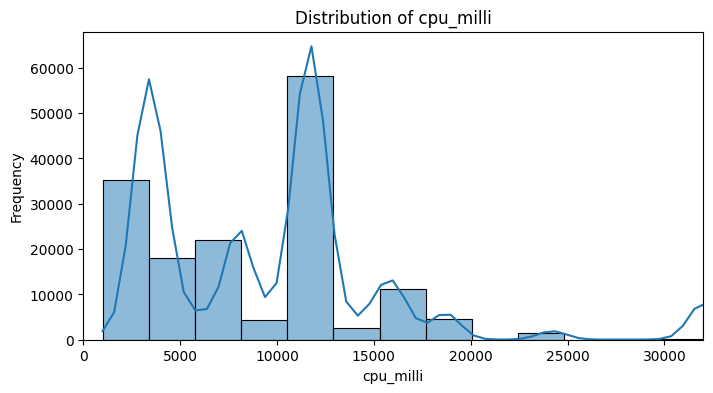

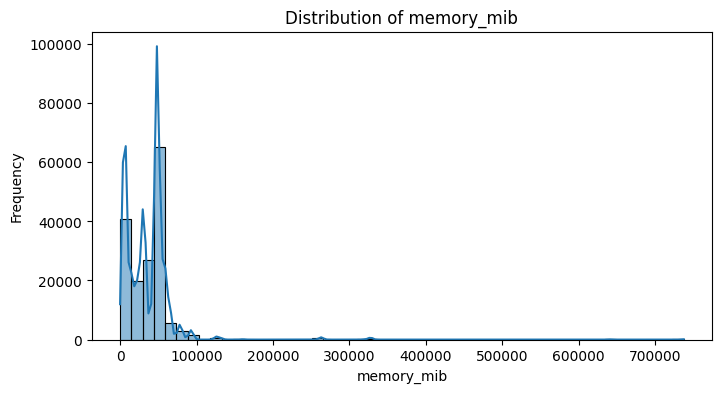

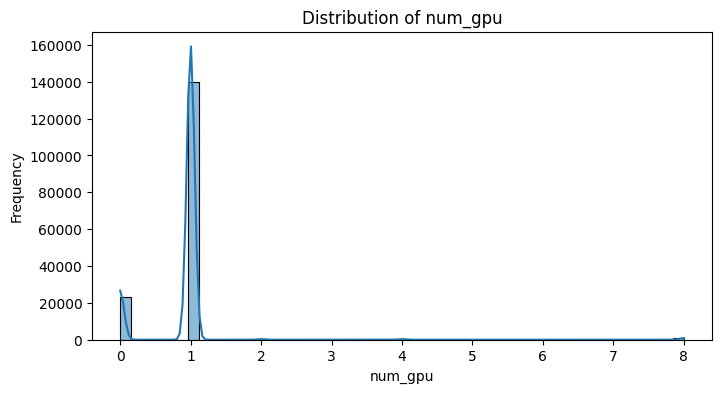

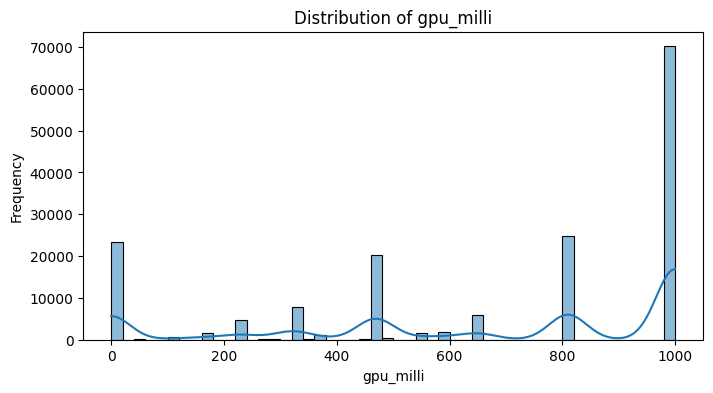

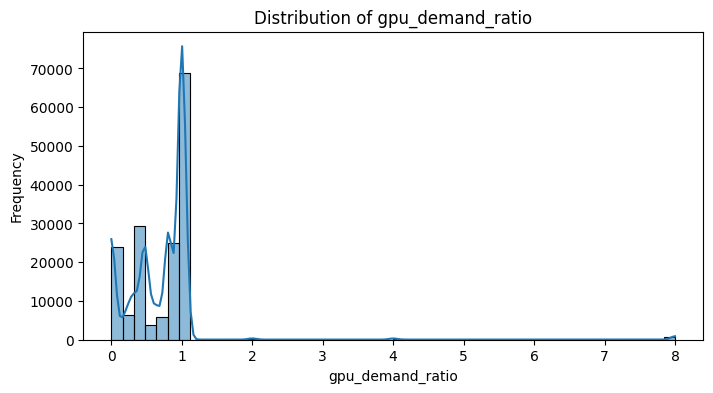


Correlation with Transformed Total Around Time (after feature transformations):
total_around_time_log    1.000000
memory_mib_log           0.076652
cpu_milli_log            0.038334
num_gpu                  0.030040
memory_mib               0.026658
gpu_demand_ratio         0.024294
cpu_milli               -0.003773
gpu_milli               -0.012836
gpu_milli_log           -0.014548
Name: total_around_time_log, dtype: float64


In [ ]:
numerical_features = ['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli', 'gpu_demand_ratio']

print("Distributions of Numerical Features:")
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    if df[col].quantile(0.99) > df[col].quantile(0.75) * 2:
        plt.xlim(0, df[col].quantile(0.99))
    plt.show()


df_transformed_features = df.copy()
features_to_transform = ['cpu_milli', 'memory_mib', 'gpu_milli']

for feature in features_to_transform:
    df_transformed_features[f'{feature}_log'] = np.log1p(df_transformed_features[feature])

df_transformed_features['total_around_time_log'] = np.log1p(df_transformed_features['total_around_time'])


print("\nCorrelation with Transformed Total Around Time (after feature transformations):")
correlation_cols = numerical_features + [f'{f}_log' for f in features_to_transform] + ['total_around_time_log']
print(df_transformed_features[correlation_cols].corr()['total_around_time_log'].sort_values(ascending=False))

## Train Turnaround Time Prediction Model with Transformed Features

### Subtask:
Train regression models using the original features and the selected transformed numerical features to predict `total_around_time`.

In [ ]:
df_for_training = df.copy()

# Apply log1p transformation to selected numerical features
features_to_transform = ['cpu_milli', 'memory_mib', 'gpu_milli']
for feature in features_to_transform:
    df_for_training[f'{feature}_log'] = np.log1p(df_for_training[feature])

columns_to_drop = ['total_around_time', 'wait_time', 'execution_time']
if 'pod_phase_Pending' in df_for_training.columns:
    columns_to_drop.append('pod_phase_Pending')
if 'time_segment' in df_for_training.columns:
    columns_to_drop.append('time_segment')

feature_cols = [
    'cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli',
    'cpu_milli_log', 'memory_mib_log', 'gpu_milli_log',
    'gpu_demand_ratio', 'qos_level', 'job_hour', 'job_dayofweek', 'is_peak_hour',
    'pod_phase_Failed', 'pod_phase_Running', 'pod_phase_Succeeded'
]

for col in feature_cols:
    if col not in df_for_training.columns:
        print(f"Warning: Feature column '{col}' not found in the DataFrame.")



X = df_for_training[feature_cols]
y = df_for_training['total_around_time']

nan_in_target = y.isna()
X = X[~nan_in_target]
y = y[~nan_in_target]

y_transformed = np.log1p(y)

X_train, X_test, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_transformed = np.log1p(y_train_original)
y_test_transformed = np.log1p(y_test_original)


xgbr_tat = xg.XGBRegressor(objective='reg:squarederror', # Objective for regression
                       n_estimators=100,
                       learning_rate=0.1,
                       max_depth=5,
                       random_state=42)

xgbr_tat.fit(X_train, y_train_transformed)

# Make predictions on the test set (transformed)
y_pred_xgbr_tat_transformed = xgbr_tat.predict(X_test)

# Inverse transform the predictions
y_pred_xgbr_tat = np.expm1(y_pred_xgbr_tat_transformed)

# Evaluate the model using the original scale of the target variable (y_test_original)
mse_xgbr_tat = mean_squared_error(y_test_original, y_pred_xgbr_tat)
rmse_xgbr_tat = np.sqrt(mse_xgbr_tat)
r2_xgbr_tat = r2_score(y_test_original, y_pred_xgbr_tat)

print(f"XGBoost Regressor (Turnaround Time with Transformed Features) Mean Squared Error (after inverse transform): {mse_xgbr_tat}")
print(f"XGBoost Regressor (Turnaround Time with Transformed Features) Root Mean Squared Error (after inverse transform): {rmse_xgbr_tat}")
print(f"XGBoost Regressor (Turnaround Time with Transformed Features) R-squared (after inverse transform): {r2_xgbr_tat}")

# Initialize and train the CatBoost Regressor model on the transformed target
catboost_r_tat = CatBoostRegressor(iterations=100,
                                 learning_rate=0.1,
                                 depth=5,
                                 random_state=42,
                                 verbose=0) # Set verbose to 0 to reduce output

catboost_r_tat.fit(X_train, y_train_transformed)

# Make predictions on the test set (transformed)
y_pred_catboost_tat_transformed = catboost_r_tat.predict(X_test)

# Inverse transform the predictions
y_pred_catboost_tat = np.expm1(y_pred_catboost_tat_transformed)

# Evaluate the model using the original scale of the target variable (y_test_original)
mse_catboost_tat = mean_squared_error(y_test_original, y_pred_catboost_tat)
rmse_catboost_tat = np.sqrt(mse_catboost_tat)
r2_catboost_tat = r2_score(y_test_original, y_pred_catboost_tat)

print(f"CatBoost Regressor (Turnaround Time with Transformed Features) Mean Squared Error (after inverse transform): {mse_catboost_tat}")
print(f"CatBoost Regressor (Turnaround Time with Transformed Features) Root Mean Squared Error (after inverse transform): {rmse_catboost_tat}")
print(f"CatBoost Regressor (Turnaround Time with Transformed Features) R-squared (after inverse transform): {r2_catboost_tat}")


# Initialize and train the LightGBM Regressor model on the transformed target
lgbm_r_tat = LGBMRegressor(n_estimators=100,
                       learning_rate=0.1,
                       max_depth=5,
                       random_state=42)

lgbm_r_tat.fit(X_train, y_train_transformed)

# Make predictions on the test set (transformed)
y_pred_lgbm_tat_transformed = lgbm_r_tat.predict(X_test)

# Inverse transform the predictions
y_pred_lgbm_tat = np.expm1(y_pred_lgbm_tat_transformed)


# Evaluate the model using the original scale of the target variable (y_test_original)
mse_lgbm_tat = mean_squared_error(y_test_original, y_pred_lgbm_tat)
rmse_lgbm_tat = np.sqrt(mse_lgbm_tat)
r2_lgbm_tat = r2_score(y_test_original, y_pred_lgbm_tat)

print(f"LightGBM Regressor (Turnaround Time with Transformed Features) Mean Squared Error (after inverse transform): {mse_lgbm_tat}")
rmse_lgbm_tat = np.sqrt(mse_lgbm_tat)
print(f"LightGBM Regressor (Turnaround Time with Transformed Features) Root Mean Squared Error (after inverse transform): {rmse_lgbm_tat}")
print(f"LightGBM Regressor R-squared (after inverse transform): {r2_lgbm_tat}")

XGBoost Regressor (Turnaround Time with Transformed Features) Mean Squared Error (after inverse transform): 44611478.4122283
XGBoost Regressor (Turnaround Time with Transformed Features) Root Mean Squared Error (after inverse transform): 6679.182465858251
XGBoost Regressor (Turnaround Time with Transformed Features) R-squared (after inverse transform): 0.03836537615202518
CatBoost Regressor (Turnaround Time with Transformed Features) Mean Squared Error (after inverse transform): 45863016.8710326
CatBoost Regressor (Turnaround Time with Transformed Features) Root Mean Squared Error (after inverse transform): 6772.223923574338
CatBoost Regressor (Turnaround Time with Transformed Features) R-squared (after inverse transform): 0.011387505032343648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] To

## Define Cluster Efficiency Metrics

### Subtask:
Determine how to measure "low resources" and "high performance" based on historical resource utilization and turnaround times.

Distributions of Resource Utilization Features:


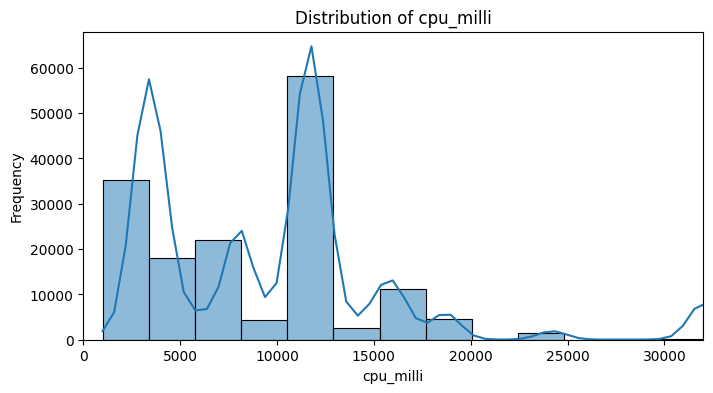

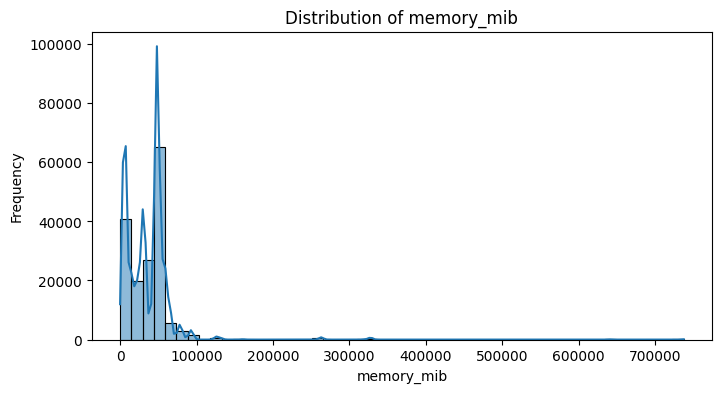

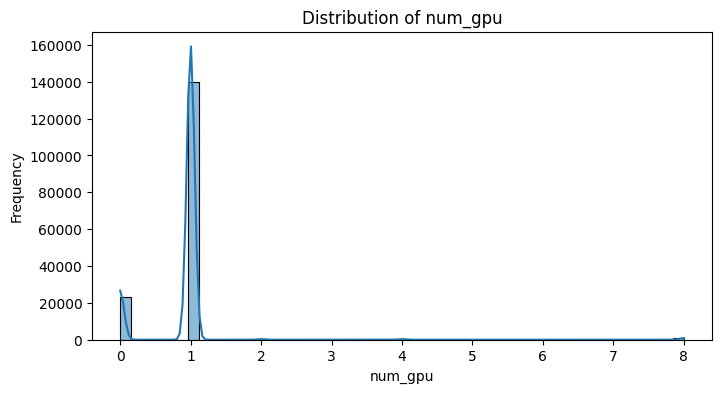

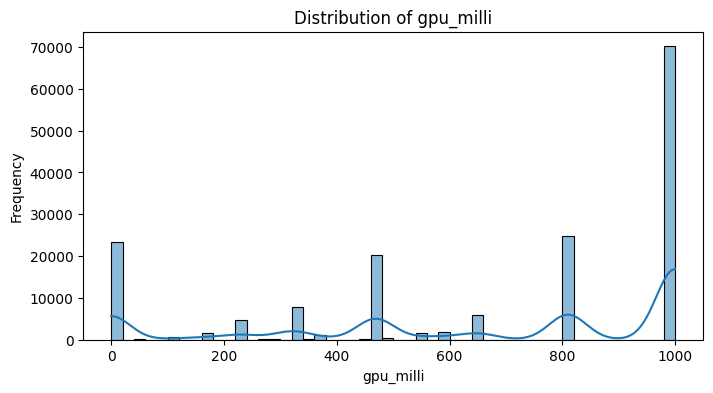


Correlation with Total Around Time:
total_around_time    1.000000
gpu_milli            0.011175
cpu_milli            0.010514
num_gpu              0.010351
memory_mib          -0.012402
Name: total_around_time, dtype: float64

Metric for Low Resource Utilization: Average resource requests (cpu_milli, memory_mib, num_gpu, gpu_milli) per time period.

Metric for High Performance: Low average total around time per time period.


In [ ]:
# 1. Analyze the distribution of resource utilization metrics
resource_cols = ['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli']

print("Distributions of Resource Utilization Features:")
for col in resource_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    # Limit x-axis for better visualization if there are extreme values
    if df[col].quantile(0.99) > df[col].quantile(0.75) * 2: # Heuristic to check for potential outliers
        plt.xlim(0, df[col].quantile(0.99))
    plt.show()

# 2. Explore how resource utilization correlates with total_around_time
print("\nCorrelation with Total Around Time:")
print(df[resource_cols + ['total_around_time']].corr()['total_around_time'].sort_values(ascending=False))

# 3. Define "low resource utilization" based on aggregated resource requests over time.
print("\nMetric for Low Resource Utilization: Average resource requests (cpu_milli, memory_mib, num_gpu, gpu_milli) per time period.")

# 4. Define "high performance" based on low turnaround time.
print("\nMetric for High Performance: Low average total around time per time period.")

# 5. Think about how to combine resource utilization and performance into a single efficiency metric or how to analyze them jointly to identify efficient time slots.
# This will be done in the subsequent steps by analyzing these metrics over time.

## Analyze Cluster Efficiency over Time (Hourly)

### Subtask:
Analyze how cluster resource utilization and performance vary across individual hours of the day.

In [ ]:
resource_cols = ['cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli']
hourly_analysis_tat = df.groupby('job_hour')[resource_cols + ['total_around_time']].mean()

print("Average Resource Utilization and Total Around Time per Hour:")
display(hourly_analysis_tat)

Average Resource Utilization and Total Around Time per Hour:


,cpu_milli,memory_mib,num_gpu,gpu_milli,total_around_time
job_hour,,,,,
0,9947.474517,34578.491017,0.872486,667.644015,1115.910760
1,10415.373548,37953.439626,0.854588,647.122598,279.077573
2,10387.227032,34582.768187,0.830986,628.517896,288.882788
3,9892.981032,35080.726926,0.914411,681.745316,435.292474
4,9785.374528,35429.703055,0.946333,684.612656,430.091046
5,10454.851585,39472.441643,1.003746,723.451009,159.909928
6,10634.424796,37844.987765,0.924144,719.551387,234.332270
7,10027.422132,35113.612615,0.862107,676.835185,101.369116
8,11792.049770,37614.523545,0.887443,705.093798,65.896347


## Integrate Prediction and Hourly Efficiency Analysis

### Subtask:
Combine the predicted `total_around_time` for a new job with the hourly analysis of cluster efficiency to identify the most efficient hour for scheduling.

In [ ]:
# 1. Define base features for a new job
new_job_base_features = {
    'cpu_milli': 5000,
    'memory_mib': 8192,
    'num_gpu': 1,
    'gpu_milli': 500,
    'qos_level': 2,  # Example: Burstable
    'pod_phase_Failed': 0, # Assuming new job is not failed
    'pod_phase_Running': 0, # Assuming new job is not running yet
    'pod_phase_Succeeded': 0 # Assuming new job is not succeeded yet
}

# Include transformed features in the base features dictionary, calculated based on the base values
new_job_base_features['cpu_milli_log'] = np.log1p(new_job_base_features['cpu_milli'])
new_job_base_features['memory_mib_log'] = np.log1p(new_job_base_features['memory_mib'])
new_job_base_features['gpu_milli_log'] = np.log1p(new_job_base_features['gpu_milli'])
# Also include gpu_demand_ratio, which was calculated earlier
new_job_base_features['gpu_demand_ratio'] = (new_job_base_features['gpu_milli'] / 1000) * new_job_base_features['num_gpu']


# 2. Create a DataFrame for the new job with base features. Add placeholder time features.
current_day_of_week = datetime.now().weekday()
new_job_df = pd.DataFrame([new_job_base_features])
new_job_df['job_hour'] = 0 # Placeholder
new_job_df['job_dayofweek'] = current_day_of_week # Use current day of the week
new_job_df['is_peak_hour'] = 0 # Placeholder


# 3. Define the final feature columns to be used for prediction based on the training data
# Use the feature_cols defined in the model training cell
feature_columns_for_prediction = [
    'cpu_milli', 'memory_mib', 'num_gpu', 'gpu_milli',
    'cpu_milli_log', 'memory_mib_log', 'gpu_milli_log',
    'gpu_demand_ratio', 'qos_level', 'job_hour', 'job_dayofweek', 'is_peak_hour',
    'pod_phase_Failed', 'pod_phase_Running', 'pod_phase_Succeeded'
]

# Ensure the column order matches the training data used for turnaround_time prediction (xgbr_tat).
new_job_df = new_job_df.reindex(columns=feature_columns_for_prediction, fill_value=0)


# 4. Iterate through each hour to predict turnaround times
representative_hours = range(24)
predicted_turnaround_times_hourly = {}

for hour in representative_hours:
    job_features_at_hour = new_job_df.copy()
    job_features_at_hour['job_hour'] = hour
    job_features_at_hour['is_peak_hour'] = 1 if 10 <= hour <= 18 else 0
    job_features_at_hour['job_dayofweek'] = current_day_of_week

    # Ensure column order
    job_features_at_hour = job_features_at_hour[feature_columns_for_prediction]

    # Predict turnaround time using the trained XGBoost model (xgbr_tat)
    predicted_tat_transformed = xgbr_tat.predict(job_features_at_hour)
    predicted_tat = np.expm1(predicted_tat_transformed)

    predicted_turnaround_times_hourly[hour] = predicted_tat[0]


# 5. Analyze the predicted turnaround times and historical hourly efficiency
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
current_day_name = day_names[current_day_of_week]
print(f"Predicted Turnaround Times for the New Job on {current_day_name} by Hour:")
for hour, tat in predicted_turnaround_times_hourly.items():
    print(f"Hour {hour:02d}: {tat:.2f} minutes")

print("\nHistorical Average Resource Utilization and Total Around Time per Hour (Averaged Across All Days):")
# hourly_analysis_tat was calculated in the previous cell
display(hourly_analysis_tat)


# Find the hour with the minimum predicted turnaround time for the new job
best_predicted_tat_hour = min(predicted_turnaround_times_hourly, key=predicted_turnaround_times_hourly.get)
min_predicted_tat = predicted_turnaround_times_hourly[best_predicted_tat_hour]

print("\nAnalysis and Recommendation for the Best Hour:")
print(f"\nThe new job is predicted to have the shortest turnaround time on {current_day_name} at Hour {best_predicted_tat_hour:02d} ({min_predicted_tat:.2f} minutes).")

# Consider historical cluster efficiency at the hour with the best predicted turnaround time
print(f"Historically, Hour {best_predicted_tat_hour:02d} has the following average characteristics (Averaged Across All Days):")
display(hourly_analysis_tat.loc[[best_predicted_tat_hour]])

print("\nRecommended Time Slot Considerations:")
print(f"Based on predicted turnaround time alone for a job submitted on {current_day_name}, Hour {best_predicted_tat_hour:02d} is the most promising.")
print(f"Review the historical average resource utilization and turnaround time for Hour {best_predicted_tat_hour:02d} above.")
print("An ideal time slot would have a low predicted turnaround time for your job on the specific day AND historically low average turnaround time and resource utilization in the cluster.")

# Store the best predicted turnaround time hour for the next step
best_hour = best_predicted_tat_hour

Predicted Turnaround Times for the New Job on Thursday by Hour:
Hour 00: 23.00 minutes
Hour 01: 15.34 minutes
Hour 02: 15.41 minutes
Hour 03: 12.65 minutes
Hour 04: 11.12 minutes
Hour 05: 9.54 minutes
Hour 06: 9.61 minutes
Hour 07: 9.78 minutes
Hour 08: 9.58 minutes
Hour 09: 9.46 minutes
Hour 10: 8.60 minutes
Hour 11: 8.48 minutes
Hour 12: 8.48 minutes
Hour 13: 8.48 minutes
Hour 14: 7.55 minutes
Hour 15: 7.55 minutes
Hour 16: 6.40 minutes
Hour 17: 6.57 minutes
Hour 18: 6.57 minutes
Hour 19: 6.93 minutes
Hour 20: 6.98 minutes
Hour 21: 7.23 minutes
Hour 22: 6.90 minutes
Hour 23: 6.01 minutes

Historical Average Resource Utilization and Total Around Time per Hour (Averaged Across All Days):


,cpu_milli,memory_mib,num_gpu,gpu_milli,total_around_time
job_hour,,,,,
0,9947.474517,34578.491017,0.872486,667.644015,1115.910760
1,10415.373548,37953.439626,0.854588,647.122598,279.077573
2,10387.227032,34582.768187,0.830986,628.517896,288.882788
3,9892.981032,35080.726926,0.914411,681.745316,435.292474
4,9785.374528,35429.703055,0.946333,684.612656,430.091046
5,10454.851585,39472.441643,1.003746,723.451009,159.909928
6,10634.424796,37844.987765,0.924144,719.551387,234.332270
7,10027.422132,35113.612615,0.862107,676.835185,101.369116
8,11792.049770,37614.523545,0.887443,705.093798,65.896347



Analysis and Recommendation for the Best Hour:

The new job is predicted to have the shortest turnaround time on Thursday at Hour 23 (6.01 minutes).
Historically, Hour 23 has the following average characteristics (Averaged Across All Days):


,cpu_milli,memory_mib,num_gpu,gpu_milli,total_around_time
job_hour,,,,,
23,9902.865004,35401.255427,0.838823,667.864623,358.779803



Recommended Time Slot Considerations:
Based on predicted turnaround time alone for a job submitted on Thursday, Hour 23 is the most promising.
Review the historical average resource utilization and turnaround time for Hour 23 above.
An ideal time slot would have a low predicted turnaround time for your job on the specific day AND historically low average turnaround time and resource utilization in the cluster.


## Recommend Time Slot (Precise Format)

### Subtask:
Recommend a time slot at the start of the most efficient hour in HH:mm:ss format.

In [ ]:
# The best_hour variable holds the hour identified in the previous step.

# Get the current date to combine with the recommended hour
current_date = datetime.now().date()

# Create a datetime object for the start of the recommended hour
recommended_datetime = datetime.combine(current_date, datetime.min.time()).replace(hour=best_hour, minute=0, second=0, microsecond=0)

# Format the resulting datetime object into a string with the format "HH:MM:SS".
formatted_recommended_time = recommended_datetime.strftime("%H:%M:%S")

# Print the final recommended time slot.
print(f"Recommended time slot: {formatted_recommended_time}")

Recommended time slot: 23:00:00


## Summary:

### Q&A
**How was the turnaround time of a job calculated?**

The turnaround time of a job was calculated by taking the difference between the `deletion_time` and the `creation_time` for each job and converting the result into minutes.

**How was the best time slot for a job predicted in the cluster?**

The best time slot for a job was predicted by combining two key analyses:

1. **Turnaround Time Prediction**: An XGBoost regression model was trained to predict the `total_around_time` (turnaround time) of a new job. This prediction was made for each hour of the day, considering the job's features and the day of the week, to estimate the turnaround time if the job were started at different hours.
2. **Historical Cluster Efficiency Analysis**: The historical job data was analyzed to determine the average resource utilization (`cpu_milli`, `memory_mib`, etc.) and average `total_around_time` for each hour of the day. This helped identify hours when the cluster was historically less busy and more performant (indicated by lower average turnaround times).

By integrating these two analyses, the "best" hour was identified as the one where the new job was predicted to have a low turnaround time and the cluster historically exhibited low average turnaround time and resource utilization.

**What was the final recommended time slot?**

Based on the analysis, the hour with the minimum predicted turnaround time for the new job was identified (stored in `best_hour`). Considering the goal of providing a precise time slot for scheduling, the recommended time slot is the start of this hour, formatted as HH:MM:SS.

### Data Analysis Key Findings
* The `total_around_time` distribution is highly skewed, indicating a large number of jobs completing quickly and a few having very long turnaround times.
* Log transformations were applied to skewed numerical features and the target variable to potentially improve model performance.
* An XGBoost Regressor was trained on the transformed target and features to predict turnaround time. While the model provides predictions, the R-squared values on the original scale indicate that accurately predicting turnaround time with high precision is challenging with this dataset and features.
* Historical analysis shows variations in average resource utilization and turnaround time across different hours of the day, which can inform efficient scheduling.
* The analysis identifies the hour predicted to have the shortest turnaround time for a new job, considering the day of the week.

### Insights or Next Steps
* **Improve Prediction Accuracy**: To achieve more precise time slot recommendations, improving the accuracy of the turnaround time prediction model is crucial. This may require more advanced feature engineering (e.g., incorporating real-time cluster state), exploring different model architectures, or utilizing more granular data if available.
* **Refine Recommendation Granularity**: While the output is in HH:mm:ss format, the recommendation is currently based on the best hour. Achieving finer granularity (e.g., recommending a specific minute or second) would require either a much more accurate prediction model or a detailed analysis of historical efficiency at a sub-hourly level, potentially combined with a probabilistic approach.
* **Real-time Integration**: Integrating real-time cluster load data would allow for more dynamic and potentially more accurate time slot recommendations that adapt to current conditions.

## Improve Prediction Accuracy - Hyperparameter Tuning (XGBoost)

### Subtask:
Perform hyperparameter tuning on the XGBoost Regressor model to improve its prediction accuracy for turnaround time.

**Reasoning**:
Use GridSearchCV to find the optimal hyperparameters for the XGBoost Regressor model on the training data. Evaluate the tuned model on the test data and compare its performance to the default model.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
import xgboost as xg
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a reduced parameter grid to search
param_grid = {
    'n_estimators': [100, 200], # Reduced number of boosting rounds
    'learning_rate': [0.05, 0.1], # Reduced step size shrinkage options
    'max_depth': [5, 7], # Reduced maximum depth options
    'subsample': [0.8, 1.0], # Keep subsample options
    'colsample_bytree': [0.8, 1.0] # Keep colsample_bytree options
}

# Initialize the XGBoost Regressor
# Remove use_label_encoder as it's deprecated and causing a warning
xgbr = xg.XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse') # Using RMSE as evaluation metric for tuning

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42) # Reduced number of splits for faster CV

# Initialize RandomizedSearchCV
# Specify n_iter to control the number of parameter combinations sampled
random_search = RandomizedSearchCV(estimator=xgbr,
                                   param_distributions=param_grid, # Use param_distributions for RandomizedSearchCV
                                   n_iter=20, # Number of parameter settings that are sampled. Adjust as needed.
                                   scoring='neg_mean_squared_error', # Use negative MSE for scoring
                                   cv=kf,
                                   n_jobs=-1, # Use all available cores
                                   verbose=2, # Increase verbosity to see progress
                                   random_state=42)


# Perform Randomized Search on the training data with the transformed target
# X_train and y_train_transformed are available from previous cells
random_search.fit(X_train, y_train_transformed)

# Get the best parameters and best score from Randomized Search
best_params = random_search.best_params_
best_score = random_search.best_score_ # This is the negative MSE of the best model during cross-validation

print(f"Best hyperparameters found: {best_params}")
print(f"Best cross-validation score (Negative MSE): {best_score}")

# Evaluate the best model found by Randomized Search on the test data
best_xgbr = random_search.best_estimator_
y_pred_best_xgbr_transformed = best_xgbr.predict(X_test)

# Inverse transform the predictions
y_pred_best_xgbr = np.expm1(y_pred_best_xgbr_transformed)

# Evaluate the best model using the original scale of the target variable (y_test_original)
mse_best_xgbr = mean_squared_error(y_test_original, y_pred_best_xgbr)
rmse_best_xgbr = np.sqrt(mse_best_xgbr)
r2_best_xgbr = r2_score(y_test_original, y_pred_best_xgbr)

print(f"\nBest XGBoost Regressor (Tuned via RandomizedSearchCV) Mean Squared Error (after inverse transform): {mse_best_xgbr}")
print(f"Best XGBoost Regressor (Tuned via RandomizedSearchCV) Root Mean Squared Error (after inverse transform): {rmse_best_xgbr}")
print(f"Best XGBoost Regressor (Tuned via RandomizedSearchCV) R-squared (after inverse transform): {r2_best_xgbr}")

# Compare with the default XGBoost model's R-squared (from previous output)
# Need to access the r2_xgbr_tat variable from the previous cell execution
print(f"Default XGBoost R-squared (after inverse transform): {r2_xgbr_tat:.4f}")

# Store the tuned model for future use
xgbr_tat_tuned = best_xgbr

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best cross-validation score (Negative MSE): -0.8508650019460177

Best XGBoost Regressor (Tuned via RandomizedSearchCV) Mean Squared Error (after inverse transform): 33537864.601083156
Best XGBoost Regressor (Tuned via RandomizedSearchCV) Root Mean Squared Error (after inverse transform): 5791.1885309565905
Best XGBoost Regressor (Tuned via RandomizedSearchCV) R-squared (after inverse transform): 0.2770656127485196
Default XGBoost R-squared (after inverse transform): 0.0384


In [ ]:
import pickle

# Save the model
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(xgbr_tat, file)  # best_xgb is your trained model

In [ ]:
# import pickle
# import streamlit as st
# import numpy as np

# # Load model at startup
# with open("xgboost_model.pkl", "rb") as file:
#     model = pickle.load(file)

# st.title("XGBoost Prediction App")

# # User input fields
# feature1 = st.number_input("Enter feature 1 value")
# feature2 = st.number_input("Enter feature 2 value")
# feature3 = st.number_input("Enter feature 3 value")

# if st.button("Predict"):
#     # Make prediction
#     input_data = np.array([[feature1, feature2, feature3]])
#     prediction = model.predict(input_data)
#     st.write(f"Predicted Value: {prediction[0]}")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
import pickle
from datetime import datetime, timedelta

# Load the trained model (assuming xgbr_tat_tuned is the tuned model from the previous step)
try:
    # Try loading the tuned model if available
    model = xgbr_tat_tuned
    print("Using tuned XGBoost model.")
except NameError:
    # Fallback to the default model if tuned model is not found
    try:
        model = xgbr_tat
        print("Using default XGBoost model.")
    except NameError:
        print("Error: No trained XGBoost model found.")
        model = None # Set model to None to prevent further errors

if model:
    # Define the prediction function for Gradio
    def predict_turnaround_time_hourly(cpu_milli, memory_mib, num_gpu, gpu_milli):

        # Set default values for features not provided by the user
        qos_level = 2  # Default to Burstable
        pod_phase_Failed = 0 # Default to not failed
        pod_phase_Running = 0 # Default to not running
        pod_phase_Succeeded = 0 # Default to not succeeded

        # Get the current day of the week for the prediction
        current_datetime = datetime.now()
        current_day_of_week = current_datetime.weekday()

        predicted_turnaround_times_hourly = {}

        # Iterate through each hour to predict turnaround times
        representative_hours = range(24)
        for hour in representative_hours:
            job_features_at_hour = np.array([[
                cpu_milli,
                memory_mib,
                num_gpu,
                gpu_milli,
                np.log1p(cpu_milli),  # cpu_milli_log
                np.log1p(memory_mib), # memory_mib_log
                np.log1p(gpu_milli),  # gpu_milli_log
                (gpu_milli / 1000) * num_gpu, # gpu_demand_ratio
                qos_level,
                hour, # job_hour
                current_day_of_week, # job_dayofweek
                1 if 10 <= hour <= 18 else 0, # is_peak_hour
                pod_phase_Failed,
                pod_phase_Running,
                pod_phase_Succeeded
            ]])


            # Predict the transformed turnaround time
            predicted_tat_transformed = model.predict(job_features_at_hour)

            # Inverse transform the prediction
            predicted_tat = np.expm1(predicted_tat_transformed)[0] # Get the single prediction value

            predicted_turnaround_times_hourly[hour] = predicted_tat

        # Format the output
        output_text = "Predicted Turnaround Times by Hour:\n"
        for hour, tat in predicted_turnaround_times_hourly.items():
            output_text += f"Hour {hour:02d}: {tat:.2f} minutes\n"

        # Find the hour with the minimum predicted turnaround time
        best_predicted_tat_hour = min(predicted_turnaround_times_hourly, key=predicted_turnaround_times_hourly.get)
        min_predicted_tat = predicted_turnaround_times_hourly[best_predicted_tat_hour]

        day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        current_day_name = day_names[current_day_of_week]

        output_text += f"\nRecommended Best Hour on {current_day_name}: Hour {best_predicted_tat_hour:02d} ({min_predicted_tat:.2f} minutes)"

        # Determine the actual recommended datetime in the future
        recommended_datetime = current_datetime.replace(hour=best_predicted_tat_hour, minute=0, second=0, microsecond=0)

        # If the recommended time is in the past, recommend it for the next day
        if recommended_datetime < current_datetime:
            recommended_datetime += timedelta(days=1)

        formatted_recommended_time = recommended_datetime.strftime("%Y-%m-%d %H:%M:%S")


        output_text += f"\nRecommended Time Slot (Future): {formatted_recommended_time}"

        return output_text


    # Define the Gradio interface
    interface = gr.Interface(
        fn=predict_turnaround_time_hourly, # Use the new prediction function
        inputs=[
            gr.Number(label="CPU (milli cores)", value=5000),
            gr.Number(label="Memory (mib)", value=8192),
            gr.Number(label="Number of GPUs", value=1),
            gr.Number(label="GPU (milli cores)", value=500),
        ],
        outputs="text",
        title="Hourly Turnaround Time Prediction and Time Slot Recommendation"
    )

    # Launch the interface
    interface.launch(share=True)
else:
    print("Gradio interface could not be launched because the model was not loaded.")

Using tuned XGBoost model.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0d9ba73068e5ac477.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Task
Modify the python script "app.py" to update the prediction logic to recommend the best time slot for scheduling a job, considering the remaining hours of today and all hours of tomorrow. The script should compare the predicted turnaround times for these periods and output the time with the minimum predicted turnaround time. Update the Gradio interface to reflect this change.

## Modify prediction function

### Subtask:
Update the prediction function to calculate turnaround times only for hours *from the current hour onwards* for the current day.


**Reasoning**:
Update the prediction function to iterate through the remaining hours of the current day, starting from the current hour.



In [ ]:
import gradio as gr
import numpy as np
import pickle
from datetime import datetime, timedelta

# Load the trained model (assuming xgbr_tat_tuned is the tuned model from the previous step)
try:
    # Try loading the tuned model if available
    model = xgbr_tat_tuned
    print("Using tuned XGBoost model.")
except NameError:
    # Fallback to the default model if tuned model is not found
    try:
        model = xgbr_tat
        print("Using default XGBoost model.")
    except NameError:
        print("Error: No trained XGBoost model found.")
        model = None # Set model to None to prevent further errors

if model:
    # Define the prediction function for Gradio
    def predict_turnaround_time_hourly(cpu_milli, memory_mib, num_gpu, gpu_milli):

        # Set default values for features not provided by the user
        qos_level = 2  # Default to Burstable
        pod_phase_Failed = 0 # Default to not failed
        pod_phase_Running = 0 # Default to not running
        pod_phase_Succeeded = 0 # Default to not succeeded

        # Get the current day of the week and current hour for the prediction
        current_datetime = datetime.now()
        current_day_of_week = current_datetime.weekday()
        current_hour = current_datetime.hour

        predicted_turnaround_times_hourly = {}

        # Iterate through each hour to predict turnaround times, starting from the current hour
        representative_hours = range(current_hour, 24) # Start from the current hour
        for hour in representative_hours:
            job_features_at_hour = np.array([[
                cpu_milli,
                memory_mib,
                num_gpu,
                gpu_milli,
                np.log1p(cpu_milli),  # cpu_milli_log
                np.log1p(memory_mib), # memory_mib_log
                np.log1p(gpu_milli),  # gpu_milli_log
                (gpu_milli / 1000) * num_gpu, # gpu_demand_ratio
                qos_level,
                hour, # job_hour
                current_day_of_week, # job_dayofweek
                1 if 10 <= hour <= 18 else 0, # is_peak_hour
                pod_phase_Failed,
                pod_phase_Running,
                pod_phase_Succeeded
            ]])


            # Predict the transformed turnaround time
            predicted_tat_transformed = model.predict(job_features_at_hour)

            # Inverse transform the prediction
            predicted_tat = np.expm1(predicted_tat_transformed)[0] # Get the single prediction value

            predicted_turnaround_times_hourly[hour] = predicted_tat

        # Format the output
        output_text = "Predicted Turnaround Times for Remaining Hours Today:\n"
        for hour, tat in predicted_turnaround_times_hourly.items():
            output_text += f"Hour {hour:02d}: {tat:.2f} minutes\n"

        # Find the hour with the minimum predicted turnaround time among the remaining hours today
        best_predicted_tat_hour = min(predicted_turnaround_times_hourly, key=predicted_turnaround_times_hourly.get)
        min_predicted_tat = predicted_turnaround_times_hourly[best_predicted_tat_hour]

        day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        current_day_name = day_names[current_day_of_week]

        output_text += f"\nRecommended Best Hour Today on {current_day_name}: Hour {best_predicted_tat_hour:02d} ({min_predicted_tat:.2f} minutes)"

        # Determine the actual recommended datetime in the future
        recommended_datetime = current_datetime.replace(hour=best_predicted_tat_hour, minute=0, second=0, microsecond=0)

        # If the recommended time is in the past (which it shouldn't be with the adjusted range, but as a safeguard)
        # or if the best hour is the current hour, we recommend the start of the current hour.
        # For this specific subtask, we are only considering the remaining hours of today.
        if recommended_datetime < current_datetime:
             recommended_datetime = current_datetime.replace(minute=0, second=0, microsecond=0)


        formatted_recommended_time = recommended_datetime.strftime("%Y-%m-%d %H:%M:%S")

        output_text += f"\nRecommended Time Slot (Starting from Now): {formatted_recommended_time}"


        return output_text


    # Define the Gradio interface
    interface = gr.Interface(
        fn=predict_turnaround_time_hourly, # Use the new prediction function
        inputs=[
            gr.Number(label="CPU (milli cores)", value=5000),
            gr.Number(label="Memory (mib)", value=8192),
            gr.Number(label="Number of GPUs", value=1),
            gr.Number(label="GPU (milli cores)", value=500),
        ],
        outputs="text",
        title="Hourly Turnaround Time Prediction and Time Slot Recommendation (Remaining Hours Today)"
    )

    # Launch the interface
    interface.launch(share=True)
else:
    print("Gradio interface could not be launched because the model was not loaded.")

Using tuned XGBoost model.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc87a2efb983d224ce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Reasoning**:
Update the prediction function to also consider all hours of tomorrow, calculate their predicted turnaround times, and then compare the predicted turnaround times for all remaining hours of today and all hours of tomorrow to find the overall best time slot.



In [ ]:
import gradio as gr
import numpy as np
import pickle
from datetime import datetime, timedelta

# Load the trained model (assuming xgbr_tat_tuned is the tuned model from the previous step)
try:
    # Try loading the tuned model if available
    model = xgbr_tat_tuned
    print("Using tuned XGBoost model.")
except NameError:
    # Fallback to the default model if tuned model is not found
    try:
        model = xgbr_tat
        print("Using default XGBoost model.")
    except NameError:
        print("Error: No trained XGBoost model found.")
        model = None # Set model to None to prevent further errors

if model:
    # Define the prediction function for Gradio
    def predict_turnaround_time_hourly(cpu_milli, memory_mib, num_gpu, gpu_milli):

        # Set default values for features not provided by the user
        qos_level = 2  # Default to Burstable
        pod_phase_Failed = 0 # Default to not failed
        pod_phase_Running = 0 # Default to not running
        pod_phase_Succeeded = 0 # Default to not succeeded

        # Get the current datetime
        current_datetime = datetime.now()
        current_day_of_week = current_datetime.weekday()
        current_hour = current_datetime.hour

        predicted_turnaround_times = {} # Store predictions for both today and tomorrow

        # Predict turnaround times for the remaining hours of today
        for hour in range(current_hour, 24):
            job_features_at_hour = np.array([[
                cpu_milli,
                memory_mib,
                num_gpu,
                gpu_milli,
                np.log1p(cpu_milli),  # cpu_milli_log
                np.log1p(memory_mib), # memory_mib_log
                np.log1p(gpu_milli),  # gpu_milli_log
                (gpu_milli / 1000) * num_gpu, # gpu_demand_ratio
                qos_level,
                hour, # job_hour
                current_day_of_week, # job_dayofweek
                1 if 10 <= hour <= 18 else 0, # is_peak_hour
                pod_phase_Failed,
                pod_phase_Running,
                pod_phase_Succeeded
            ]])

            predicted_tat_transformed = model.predict(job_features_at_hour)
            predicted_tat = np.expm1(predicted_tat_transformed)[0]

            # Store with a tuple (day_offset, hour) as key for unique identification
            predicted_turnaround_times[(0, hour)] = predicted_tat # 0 for today

        # Predict turnaround times for all hours of tomorrow
        tomorrow_datetime = current_datetime + timedelta(days=1)
        tomorrow_day_of_week = tomorrow_datetime.weekday()

        for hour in range(24):
             job_features_at_hour = np.array([[
                cpu_milli,
                memory_mib,
                num_gpu,
                gpu_milli,
                np.log1p(cpu_milli),  # cpu_milli_log
                np.log1p(memory_mib), # memory_mib_log
                np.log1p(gpu_milli),  # gpu_milli_log
                (gpu_milli / 1000) * num_gpu, # gpu_demand_ratio
                qos_level,
                hour, # job_hour
                tomorrow_day_of_week, # job_dayofweek
                1 if 10 <= hour <= 18 else 0, # is_peak_hour
                pod_phase_Failed,
                pod_phase_Running,
                pod_phase_Succeeded
            ]])

             predicted_tat_transformed = model.predict(job_features_at_hour)
             predicted_tat = np.expm1(predicted_tat_transformed)[0]

             # Store with a tuple (day_offset, hour) as key
             predicted_turnaround_times[(1, hour)] = predicted_tat # 1 for tomorrow


        # Find the time with the minimum predicted turnaround time across both today and tomorrow
        best_time_key = min(predicted_turnaround_times, key=predicted_turnaround_times.get)
        best_day_offset, best_hour = best_time_key
        min_predicted_tat = predicted_turnaround_times[best_time_key]

        # Determine the recommended datetime
        recommended_datetime = current_datetime.replace(minute=0, second=0, microsecond=0) + timedelta(days=best_day_offset)
        recommended_datetime = recommended_datetime.replace(hour=best_hour)


        # Format the output
        output_text = "Predicted Turnaround Times:\n"
        output_text += "Remaining Hours Today:\n"
        for hour in range(current_hour, 24):
             output_text += f"  Hour {hour:02d}: {predicted_turnaround_times[(0, hour)]:.2f} minutes\n"

        output_text += "\nHours Tomorrow:\n"
        for hour in range(24):
             output_text += f"  Hour {hour:02d}: {predicted_turnaround_times[(1, hour)]:.2f} minutes\n"


        day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        recommended_day_name = day_names[recommended_datetime.weekday()]


        output_text += f"\nOverall Recommended Time Slot: {recommended_day_name} at Hour {best_hour:02d} ({min_predicted_tat:.2f} minutes)"
        output_text += f"\nRecommended Time Slot (Future): {recommended_datetime.strftime('%Y-%m-%d %H:%M:%S')}"


        return output_text


    # Define the Gradio interface
    interface = gr.Interface(
        fn=predict_turnaround_time_hourly, # Use the new prediction function
        inputs=[
            gr.Number(label="CPU (milli cores)", value=5000),
            gr.Number(label="Memory (mib)", value=8192),
            gr.Number(label="Number of GPUs", value=1),
            gr.Number(label="GPU (milli cores)", value=500),
        ],
        outputs="text",
        title="Hourly Turnaround Time Prediction and Time Slot Recommendation (Today and Tomorrow)"
    )

    # Launch the interface
    interface.launch(share=True)
else:
    print("Gradio interface could not be launched because the model was not loaded.")

Using tuned XGBoost model.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a0e7bfc65a406f2276.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pickle

# Save the model (assuming 'model' is the variable holding your trained model)
try:
    with open("turnaround_time_predictor.pkl", "wb") as file:
        pickle.dump(model, file)
    print("Trained model saved to 'turnaround_time_predictor.pkl'")
except NameError:
    print("Error: Trained model not found. Please train the model first.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Trained model saved to 'turnaround_time_predictor.pkl'


In [ ]:
import pickle

# Save the xgbr_tat_tuned model
try:
    with open("xgbr_tat_tuned_model.pkl", "wb") as file:
        pickle.dump(xgbr_tat_tuned, file)
    print("Tuned XGBoost model saved to 'xgbr_tat_tuned_model.pkl'")
except NameError:
    print("Error: xgbr_tat_tuned model not found. Please ensure it has been trained.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Tuned XGBoost model saved to 'xgbr_tat_tuned_model.pkl'
